# Decision Trees: Entropy vs Gini (4-class tiny dataset)
This notebook reproduces the **10-sample dataset** from our board example and shows—step by step—how a decision tree chooses splits using:
- **Entropy / Information Gain**
- **Gini index / Gini reduction**

**No user-defined functions**


## 1) Dataset (10 samples, 4 classes)
Features:
- `Hours` ∈ {High, Low}
- `Strategy` ∈ {Yes, No}

Target classes (4): A, E, S, K


In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.DataFrame({
 'ID':[1,2,3,4,5,6,7,8,9,10],
 'Hours':['High','High','High','High','Low','Low','Low','Low','Low','High'],
 'Strategy':['Yes','Yes','Yes','No','Yes','Yes','No','No','No','No'],
 'Class':['A','A','E','K','A','E','S','K','S','A']
})

In [3]:
df

,ID,Hours,Strategy,Class
0,1,High,Yes,A
1,2,High,Yes,A
2,3,High,Yes,E
3,4,High,No,K
4,5,Low,Yes,A
5,6,Low,Yes,E
6,7,Low,No,S
7,8,Low,No,K
8,9,Low,No,S
9,10,High,No,A


## 2) Objective (Iteration 1)
At the root node we choose the split that makes child nodes **more pure**.

### Entropy
\[H(S)=-\sum_c p(c)\log_2 p(c)\]
Information Gain:
\[IG = H(parent)-\sum_v \frac{|S_v|}{|S|}H(S_v)\]

### Gini
\[G(S)=1-\sum_c p(c)^2\]
Gini reduction:
\[\Delta G = G(parent)-\sum_v \frac{|S_v|}{|S|}G(S_v)\]

**Algorithms (names):**
- **ID3**: entropy + information gain
- **C4.5**: entropy family (gain ratio)
- **CART**: gini for classification (and MSE for regression)


## 3) Root impurity (Entropy + Gini)

In [4]:
counts = df['Class'].value_counts().sort_index()
counts

Class
A    4
E    2
K    2
S    2
Name: count, dtype: int64

In [5]:
p = (counts / counts.sum()).values
p
# no. of times a sample appears/ Total number of samples = 4/10

array([0.4, 0.2, 0.2, 0.2])

In [6]:
H_root = -np.sum(p * np.log2(p)) # sigma(p*ln2(1/p)) -ENTROPY
G_root = 1 - np.sum(p**2) # Gini Index - 0 and 1

In [7]:
H_root, G_root

(1.9219280948873623, 0.72)

## 4) Iteration 1: try split on `Strategy`

In [8]:
yes = df[df['Strategy']=='Yes']
no  = df[df['Strategy']=='No']

In [9]:
yes[['ID','Hours','Strategy','Class']].reset_index(drop=True)

,ID,Hours,Strategy,Class
0,1,High,Yes,A
1,2,High,Yes,A
2,3,High,Yes,E
3,5,Low,Yes,A
4,6,Low,Yes,E


In [10]:
no[['ID','Hours','Strategy','Class']].reset_index(drop=True)

,ID,Hours,Strategy,Class
0,4,High,No,K
1,7,Low,No,S
2,8,Low,No,K
3,9,Low,No,S
4,10,High,No,A


In [11]:
p_yes = (yes['Class'].value_counts() / len(yes)).values
H_yes = -np.sum(p_yes*np.log2(p_yes)); G_yes = 1 - np.sum(p_yes**2)

In [12]:
p_no = (no['Class'].value_counts() / len(no)).values
H_no = -np.sum(p_no*np.log2(p_no)); G_no = 1 - np.sum(p_no**2)

In [13]:
# Information Gain
w_yes, w_no = len(yes)/len(df), len(no)/len(df) # Weights - Decision
H_after_strategy = w_yes*H_yes + w_no*H_no; # Entropy
G_after_strategy = w_yes*G_yes + w_no*G_no # Gini Index

In [14]:
IG_strategy = H_root - H_after_strategy # ERROR between Undivided data
DG_strategy = G_root - G_after_strategy # And Divided data

In [15]:
H_yes, G_yes, H_no, G_no, IG_strategy, DG_strategy

(0.9709505944546686,
 0.48,
 1.5219280948873621,
 0.6399999999999999,
 0.6754887502163469,
 0.16000000000000003)

## 5) Iteration 1: try split on `Hours`

In [16]:
high = df[df['Hours']=='High']
low  = df[df['Hours']=='Low']

In [17]:
p_high = (high['Class'].value_counts()/len(high)).values
H_high = -np.sum(p_high*np.log2(p_high)); G_high = 1 - np.sum(p_high**2)

In [18]:
p_low = (low['Class'].value_counts()/len(low)).values
H_low = -np.sum(p_low*np.log2(p_low)); G_low = 1 - np.sum(p_low**2)

In [19]:
w_high, w_low = len(high)/len(df), len(low)/len(df)
H_after_hours = w_high*H_high + w_low*H_low; G_after_hours = w_high*G_high + w_low*G_low

In [20]:
IG_hours = H_root - H_after_hours
DG_hours = G_root - G_after_hours

In [21]:
H_high, G_high, H_low, G_low, IG_hours, DG_hours

(1.3709505944546687,
 0.5599999999999999,
 1.9219280948873623,
 0.72,
 0.2754887502163468,
 0.08000000000000007)

### Iteration 1 decision

In [22]:
pd.DataFrame({
 'Measure':['Information Gain (Entropy)','Gini reduction'],
 'Strategy':[IG_strategy, DG_strategy],
 'Hours':[IG_hours, DG_hours]
})

,Measure,Strategy,Hours
0,Information Gain (Entropy),0.675489,0.275489
1,Gini reduction,0.160000,0.080000


In [23]:
best_entropy = 'Strategy' if IG_strategy>IG_hours else 'Hours'
best_gini = 'Strategy' if DG_strategy>DG_hours else 'Hours'

In [24]:
best_entropy, best_gini

('Strategy', 'Strategy')

## 6) Iteration 2: grow only the `Strategy` branch using `Hours`
Split **inside** each Strategy branch: (Strategy=Yes → Hours) and (Strategy=No → Hours).

### 6A) Strategy=Yes → split by Hours

In [25]:
yes_high = yes[yes['Hours']=='High']
yes_low  = yes[yes['Hours']=='Low']

In [26]:
p_yh = (yes_high['Class'].value_counts()/len(yes_high)).values
H_yh = -np.sum(p_yh*np.log2(p_yh)); G_yh = 1 - np.sum(p_yh**2)

In [27]:
p_yl = (yes_low['Class'].value_counts()/len(yes_low)).values
H_yl = -np.sum(p_yl*np.log2(p_yl)); G_yl = 1 - np.sum(p_yl**2)

In [28]:
w_yh, w_yl = len(yes_high)/len(yes), len(yes_low)/len(yes)
H_yes_after = w_yh*H_yh + w_yl*H_yl; G_yes_after = w_yh*G_yh + w_yl*G_yl

In [29]:
IG_yes_local = H_yes - H_yes_after
DG_yes_local = G_yes - G_yes_after

In [30]:
H_yh, G_yh, H_yl, G_yl, IG_yes_local, DG_yes_local

(0.9182958340544896,
 0.4444444444444444,
 1.0,
 0.5,
 0.01997309402197489,
 0.013333333333333308)

### 6B) Strategy=No → split by Hours

In [31]:
no_high = no[no['Hours']=='High']
no_low  = no[no['Hours']=='Low']

In [32]:
p_nh = (no_high['Class'].value_counts()/len(no_high)).values
H_nh = -np.sum(p_nh*np.log2(p_nh)); G_nh = 1 - np.sum(p_nh**2)

In [33]:
p_nl = (no_low['Class'].value_counts()/len(no_low)).values
H_nl = -np.sum(p_nl*np.log2(p_nl)); G_nl = 1 - np.sum(p_nl**2)

In [34]:
w_nh, w_nl = len(no_high)/len(no), len(no_low)/len(no)
H_no_after = w_nh*H_nh + w_nl*H_nl; G_no_after = w_nh*G_nh + w_nl*G_nl

In [35]:
IG_no_local = H_no - H_no_after
DG_no_local = G_no - G_no_after

In [36]:
H_nh, G_nh, H_nl, G_nl, IG_no_local, DG_no_local

(1.0,
 0.5,
 0.9182958340544896,
 0.4444444444444444,
 0.5709505944546684,
 0.17333333333333323)

## 7) Visual comparison (Entropy vs Gini)
Two quick charts:
- Iteration 1: feature choice
- Iteration 2: local gains inside Strategy branches

Teaching point: entropy and gini often agree; differences are data-dependent.

### 7A) Iteration 1: feature scores

In [37]:
labels = ['Strategy','Hours']
vals_ig = [IG_strategy, IG_hours]

Text(0.5, 1.0, 'Iteration 1: Information Gain (Entropy)')

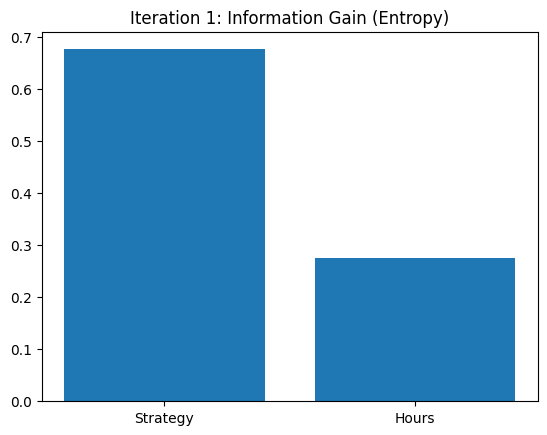

In [38]:
plt.figure(); plt.bar(labels, vals_ig)
plt.title('Iteration 1: Information Gain (Entropy)')

<BarContainer object of 2 artists>

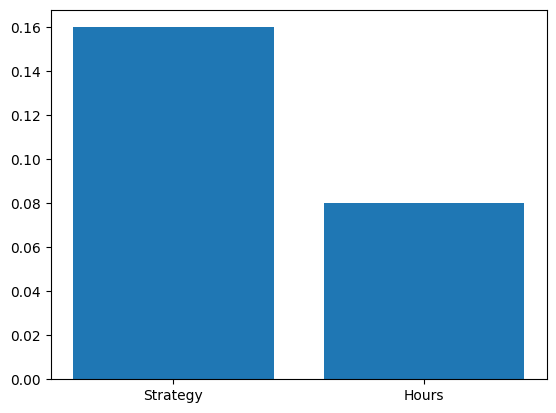

In [39]:
vals_dg = [DG_strategy, DG_hours]
plt.figure(); plt.bar(labels, vals_dg)

Text(0.5, 1.0, 'Iteration 1: Gini reduction')

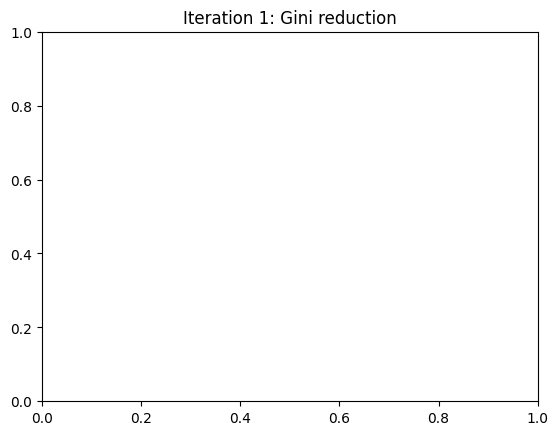

In [40]:
plt.title('Iteration 1: Gini reduction')

### 7B) Iteration 2: local scores in Strategy branches

In [41]:
labels2 = ['Strategy=Yes','Strategy=No']
vals2_ig = [IG_yes_local, IG_no_local]

Text(0.5, 1.0, 'Iteration 2: Local Information Gain (Entropy)')

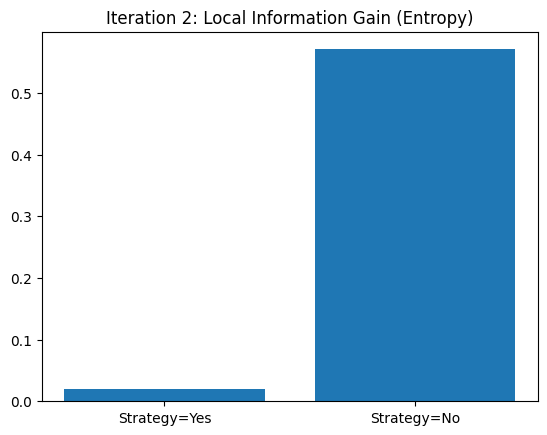

In [42]:
plt.figure(); plt.bar(labels2, vals2_ig)
plt.title('Iteration 2: Local Information Gain (Entropy)')

<BarContainer object of 2 artists>

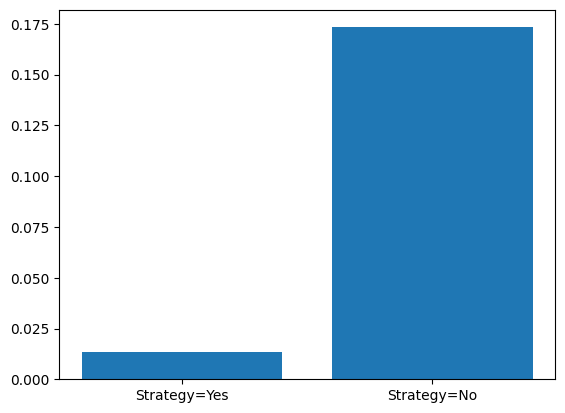

In [43]:
vals2_dg = [DG_yes_local, DG_no_local]
plt.figure(); plt.bar(labels2, vals2_dg)

Text(0.5, 1.0, 'Iteration 2: Local Gini reduction')

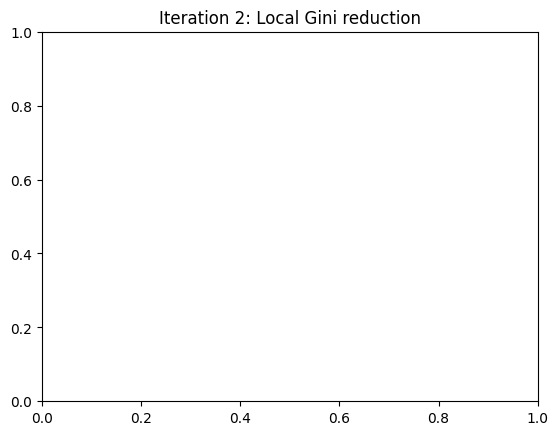

In [44]:
plt.title('Iteration 2: Local Gini reduction')

## 8) Same trees in scikit-learn (CART with different impurity criteria)
scikit-learn grows trees using **CART**, and lets you choose `criterion='gini'` or `criterion='entropy'`.
We cap `max_depth=2` to match our two iterations.

In [45]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
X = pd.get_dummies(df[['Hours','Strategy']]); y = df['Class']

In [46]:
dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=0)
dt_gini.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [47]:
dt_ent = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0)
dt_ent.fit(X, y)

,criterion,'entropy'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [48]:
print(export_text(dt_gini, feature_names=list(X.columns)))

|--- Strategy_Yes <= 0.50
|   |--- Hours_Low <= 0.50
|   |   |--- class: A
|   |--- Hours_Low >  0.50
|   |   |--- class: S
|--- Strategy_Yes >  0.50
|   |--- Hours_High <= 0.50
|   |   |--- class: A
|   |--- Hours_High >  0.50
|   |   |--- class: A



In [49]:
print(export_text(dt_ent, feature_names=list(X.columns)))

|--- Strategy_Yes <= 0.50
|   |--- Hours_Low <= 0.50
|   |   |--- class: A
|   |--- Hours_Low >  0.50
|   |   |--- class: S
|--- Strategy_Yes >  0.50
|   |--- Hours_High <= 0.50
|   |   |--- class: A
|   |--- Hours_High >  0.50
|   |   |--- class: A



### Tree plots (separate figures)

Text(0.5, 1.0, 'Decision Tree (CART) with Gini')

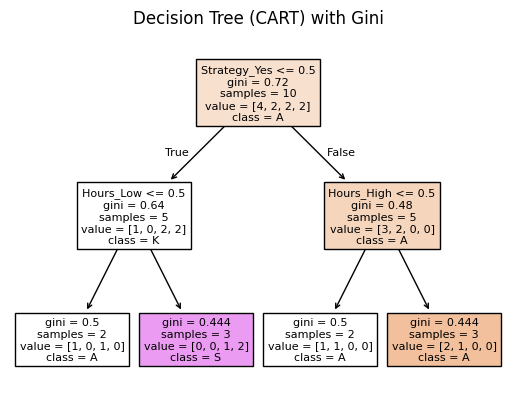

In [50]:
plt.figure(); plot_tree(dt_gini, feature_names=list(X.columns), class_names=sorted(y.unique()), filled=True)
plt.title('Decision Tree (CART) with Gini')

Text(0.5, 1.0, 'Decision Tree (CART) with Entropy')

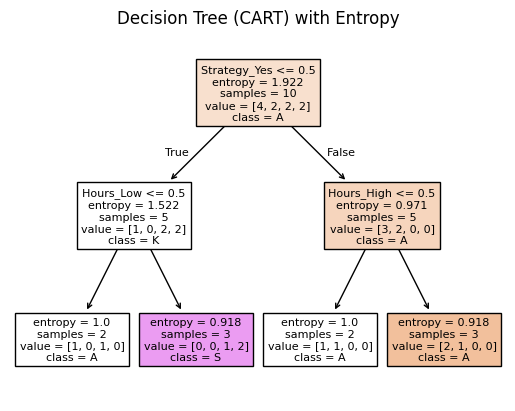

In [51]:
plt.figure(); plot_tree(dt_ent, feature_names=list(X.columns), class_names=sorted(y.unique()), filled=True)
plt.title('Decision Tree (CART) with Entropy')

## 9) Quick performance check on this tiny dataset
On many datasets they are very similar. Here we just compare training accuracy (sanity check).

In [52]:
acc_gini = dt_gini.score(X,y)
acc_ent = dt_ent.score(X,y)

In [53]:
acc_gini, acc_ent

(0.6, 0.6)

## 10) Summary
- **Entropy** measures uncertainty; **Information Gain** measures how much a question reduces it.
- **Gini** measures impurity via squared probabilities; splits reduce it.
- **ID3/C4.5** are entropy-family; **CART** is gini-family.
- Often both choose the same splits; gini is slightly faster (no logs).
